In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist
from enum import Enum

In [0]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist
from enum import Enum

# boolean variable that indicates whether or not we have gpu...
use_cuda = torch.cuda.is_available()
print("Use GPU: {}".format(use_cuda))

# Default gaussian mixture parameters
PI = 0.5

SIGMA_1 = torch.tensor([math.exp(-0)])
SIGMA_2 = torch.tensor([math.exp(-6)])

# place tensor in GPU if use_cuda
if use_cuda:
  SIGMA_1 = SIGMA_1.cuda()
  SIGMA_2 = SIGMA_2.cuda()

# Default gaussian parameters
MU_PRIOR = 0
SIGMA_PRIOR = torch.tensor([math.exp(-0)])

# place tensor in GPU if use_cuda
if use_cuda:
    SIGMA_PRIOR = SIGMA_PRIOR.cuda()

# Initial weight hyperparameters
MU_WEIGHTS = (-0.03, 0.03)
RHO_WEIGHTS = (-4.31, -4.30)
MU_BIAS = (-0.03, 0.03)
RHO_BIAS = (-4.31, -4.30)

# Loss variance for regression
SIGMA = torch.tensor([math.exp(-1)])

# place tensor in GPU if use_cuda
if use_cuda:
    SIGMA = SIGMA.cuda()

class PriorType(Enum):
  MIXTURE = 1
  GAUSSIAN = 2

class ActivationType(Enum):
  NONE = 0
  RELU = 1
  SOFTMAX = 2
  TANH = 3
  SIGMOID = 4

class TaskType(Enum):
  REGRESSION = 1
  CLASSIFICATION = 2

class GaussianMixture(object):

  def __init__(self, pi, sigma1, sigma2):
    self.pi = pi
    self.sigma1 = sigma1
    self.sigma2 = sigma2

  # arguments of dist.Normal() should be tensors rather than scalars
  def log_prob(self, weights):
    new_weights = weights.view(-1)
    normal_density1 = dist.Normal(0,self.sigma1).log_prob(new_weights)
    exp_normal_density1 = torch.exp(normal_density1)
    exp_normal_density2 = torch.exp(
        dist.Normal(0.0, self.sigma2).log_prob(new_weights))
    nonzero = exp_normal_density2.nonzero()
    zero = (exp_normal_density2==0).nonzero()
    sum_log_prob = torch.sum(torch.log(self.pi * torch.take(exp_normal_density1,nonzero) \
                  + (1-self.pi)*torch.take(exp_normal_density2,nonzero))) \
                  + torch.sum(torch.take(normal_density1, zero)+np.log(self.pi))
    return sum_log_prob

class BayesianLayer(nn.Module):

  def __init__(self,
               input_size,
               output_size,
               prior_type=PriorType.MIXTURE,
               prior_params={'pi' : PI, 'sigma1' : SIGMA_1, 'sigma2' : SIGMA_2},
               activation_type=ActivationType.NONE,
              ):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.activation_type = activation_type

    # create torch variables
    if not use_cuda:
        self.mu_weights = nn.Parameter(torch.Tensor(output_size, input_size))
        self.rho_weights = nn.Parameter(torch.Tensor(output_size, input_size))
        self.mu_bias = nn.Parameter(torch.Tensor(output_size))
        self.rho_bias = nn.Parameter(torch.Tensor(output_size))
        self.normal_dist = dist.Normal(torch.Tensor([0]), torch.Tensor([1]))
    else:
        self.mu_weights = nn.Parameter(torch.Tensor(output_size, input_size).cuda())
        self.rho_weights = nn.Parameter(torch.Tensor(output_size, input_size).cuda())
        self.mu_bias = nn.Parameter(torch.Tensor(output_size).cuda())
        self.rho_bias = nn.Parameter(torch.Tensor(output_size).cuda())
        self.normal_dist = dist.Normal(torch.Tensor([0]).cuda(), torch.Tensor([1]).cuda())

    # initialize variables
    self.mu_weights.data.uniform_(*MU_WEIGHTS)
    self.rho_weights.data.uniform_(*RHO_WEIGHTS)
    self.mu_bias.data.uniform_(*MU_BIAS)
    self.rho_bias.data.uniform_(*RHO_BIAS)

    if prior_type == PriorType.MIXTURE:
      self.prior_weights = GaussianMixture(
          prior_params['pi'], prior_params['sigma1'], prior_params['sigma2'])
      self.prior_bias = GaussianMixture(
          prior_params['pi'], prior_params['sigma1'], prior_params['sigma2'])
    else:
      self.prior_weights = dist.Normal(prior_params['mean'],
                                       prior_params['sigma'])
      self.prior_bias = dist.Normal(prior_params['mean'],
                                    prior_params['sigma'])
    self.log_prior = 0
    self.log_posterior = 0

  def _compute_gaussian_sample(self, mu, rho):
    epsilon = self.normal_dist.sample(rho.size()).squeeze(-1)
    return mu + torch.log(1 + torch.exp(rho)) * epsilon

  def forward(self, input_data, sample=False, debug=False):
    if self.training or sample:
      weights = self._compute_gaussian_sample(self.mu_weights, self.rho_weights)
      bias = self._compute_gaussian_sample(self.mu_bias, self.rho_bias)
      if debug is True:
        print("sampled weights:")
        print(weights)
      self.log_prior = (self.prior_weights.log_prob(weights).sum() +
                        self.prior_bias.log_prob(bias).sum() )
      sigma_weights = torch.log(1 + torch.exp(self.rho_weights))
      sigma_bias = torch.log(1 + torch.exp(self.rho_bias))
      self.log_posterior = (
          dist.Normal(
              self.mu_weights, sigma_weights).log_prob(weights).sum() +
          dist.Normal(self.mu_bias, sigma_bias).log_prob(bias).sum()
      )

      if torch.isnan(self.log_posterior):
        print('Weights log prob: ')
        print( dist.Normal(
              self.mu_weights, sigma_weights).log_prob(weights).sum())
        print('Bias log prob: ' )
        print(dist.Normal(self.mu_bias, sigma_bias).log_prob(bias).sum())
    else:
      weights = self.mu_weights
      bias = self.mu_bias

    linear_output = nn.functional.linear(input_data, weights, bias)
    output = linear_output
    if self.activation_type == ActivationType.RELU:
      output = torch.relu(linear_output)
    elif self.activation_type == ActivationType.SOFTMAX:
      output = torch.log_softmax(linear_output, dim=1)
    elif self.activation_type == ActivationType.SIGMOID:
      output = torch.sigmoid(linear_output)
    elif self.activation_type == ActivationType.TANH:
      output = torch.tanh(linear_output)
    elif self.activation_type == ActivationType.NONE:
      output = linear_output
    else:
      raise ValueError('activation_type {} not support'.format(self.activation_type))
    return output

  def extra_repr(self):
    return 'Bayesian Layer, in_size:{}, out_size:{}, activation_type:{}'.format(
      self.input_size, self.output_size, self.activation_type.name
    )

class BayesianNN(nn.Module):

  def __init__(
      self,
      nn_input_size,
      layer_config=[100, 100, 10],           # list of layer output sizes
      activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.NONE],
      prior_type=PriorType.MIXTURE,
      prior_params={'pi' : PI, 'sigma1' : SIGMA_1, 'sigma2' : SIGMA_2},
      task_type=TaskType.REGRESSION,         # determines the likelihood form
  ):
    super().__init__()

    self.layers = nn.ModuleList([]) # ensures that all params are registered
    self.input_size = nn_input_size
    for i, output_size in enumerate(layer_config):
      if i == 0:
        input_size = self.input_size
      else:
        input_size = layer_config[i-1]

      bayesian_layer = BayesianLayer(input_size, output_size,
                                     activation_type = activation_config[i],
                                     prior_type=prior_type,
                                     prior_params=prior_params)
      self.layers.append(bayesian_layer)
    self.output_size = self.layers[-1].output_size
    self.task_type = task_type

  def forward(self, input_data, sample=True, debug=False):
    current_data = input_data
    for layer in self.layers:
      current_data = layer.forward(current_data, sample, debug=debug)
    if sample is False:
        print("not sampling.")
    return current_data

  # sample a bunch of weights for the network
  # make predictions using sampled weights
  # output averaged predictions from different sampled weights
  def predict_by_sampling(self, input_data, num_samples=1):
    # reduce the use of memory
    with torch.no_grad():
        outputs = torch.empty(num_samples, input_data.size()[0], self.output_size)
        for i in range(num_samples):
            print("*"*20)
            outputs[i] = self.forward(input_data, sample=True, debug=True)
            print(outputs[i][0])
            print("*"*20)
        stds = outputs.std(0)
        print("std in probability distributions:", stds.mean(0))
        outputs = outputs.mean(0)
    return outputs

  def log_prior(self):
    log_prior = 0
    for layer in self.layers:
      log_prior += layer.log_prior
    return log_prior

  def log_posterior(self):
    log_posterior = 0
    for layer in self.layers:
      log_posterior += layer.log_posterior
    return log_posterior

  def cost_function(self, inputs, targets, num_samples, ratio):
    sum_log_posterior = 0
    sum_log_prior = 0
    sum_negative_log_likelihood = 0
    for n in range(num_samples):
      outputs = self(inputs, sample=True)
      sum_log_posterior += self.log_posterior()
      sum_log_prior += self.log_prior()
      if self.task_type == TaskType.CLASSIFICATION:
         # the outputs are from log_softmax activation function
         log_probs = outputs[range(targets.size()[0]), targets]
         # the negative sum of log probs is the negative log likelihood
         # for this sampled neural network on this minibatch
         negative_log_likelihood = -log_probs.sum()
         # negative_log_likelihood = nn.functional.nll_loss(outputs, targets)
      elif self.task_type == TaskType.REGRESSION:
         negative_log_likelihood = - dist.Normal(
             targets, SIGMA).log_prob(outputs).sum()
      sum_negative_log_likelihood += negative_log_likelihood
    kl_divergence = (sum_log_posterior / num_samples - sum_log_prior / num_samples) * ratio
    negative_log_likelihood = sum_negative_log_likelihood / num_samples
    loss =  kl_divergence + negative_log_likelihood
    return loss, kl_divergence, negative_log_likelihood

  def extra_repr(self):
    repr = ''
    for layer in self.layers:
      repr += layer.extra_repr()
      repr += '\n'
    return repr

Use GPU: True


In [0]:
net = BayesianNN(
    nn_input_size=1, 
    layer_config=[100, 100, 1], 
    activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.NONE], 
    prior_type=PriorType.GAUSSIAN,
    prior_params={'mean': 0, 'sigma': 10},
    task_type=TaskType.REGRESSION)
if use_cuda:
    net = net.cuda()

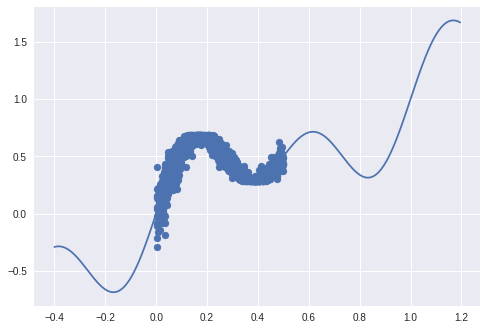

In [0]:
# Regression curves data

SAMPLE_SIZE = 1200

def noisy_function(x):
  epsilon = dist.Normal(0, 0.02).sample(torch.Size([SAMPLE_SIZE]))
  return (x + 0.3 * torch.sin(2 * math.pi * (x + epsilon)) +
          0.3 * torch.sin(4 * math.pi * (x + epsilon)) + epsilon)

def true_function(x):
  return x + 0.3 * torch.sin(2 * math.pi * x) + 0.3 * torch.sin(4 * math.pi * x)
 
trainfeatures = dist.Uniform(
    torch.tensor([0.0]), torch.tensor([0.5])).sample(torch.Size([SAMPLE_SIZE])).flatten()
trainlabels = noisy_function(trainfeatures) 

true_range = torch.arange(-0.4, 1.2, 0.005)
true_labels = true_function(true_range)

if use_cuda:
  true_range = true_range.cuda()

plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy())
plt.plot(true_range.cpu().numpy(), true_labels.flatten().cpu().numpy())
plt.plot()

trainfeatures = trainfeatures.view([SAMPLE_SIZE, 1])
trainlabels = trainlabels.view([SAMPLE_SIZE, 1])
trainset = torch.utils.data.TensorDataset(trainfeatures, trainlabels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=120,
                                          shuffle=True, num_workers=2)

loss: tensor(6429.9565, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(6361.7251, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(68.2313, device='cuda:0', grad_fn=<DivBackward0>)


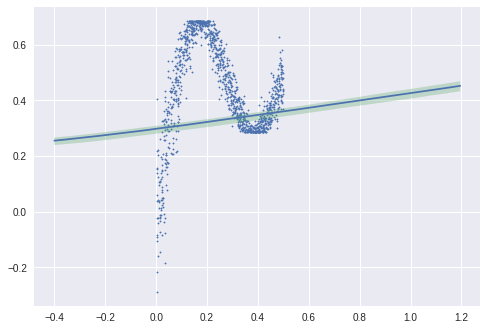

loss: tensor(6339.8931, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(6327.9961, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(11.8967, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(6304.8242, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(6298.7319, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(6.0922, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(6269.3452, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(6266.0444, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(3.3008, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(6238.0576, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(6235.1064, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.9514, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(6207.7720, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(6203.9268, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(3.8453, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(6175.2925, device='cuda:0', grad_fn=<AddB

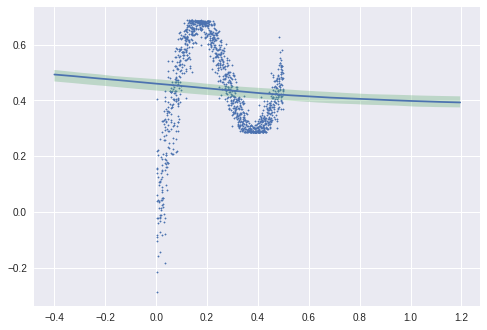

loss: tensor(6023.8613, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(6022.2329, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(1.6283, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5989.0703, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5988.9351, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.1353, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5961.2314, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5959.7930, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(1.4384, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5930.9712, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5928.2642, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.7070, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5902.8599, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5899.7163, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(3.1437, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5870.1216, device='cuda:0', grad_fn=<AddBa

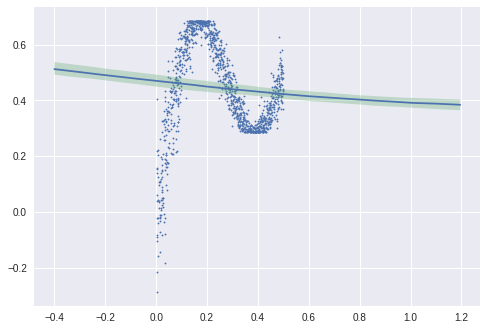

loss: tensor(5720.8159, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5714.8506, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(5.9652, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5685.2412, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5681.6558, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(3.5853, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5654.3931, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5652.0610, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.3318, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5628.1177, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5621.3179, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(6.7998, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5590.2539, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5585.1772, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(5.0765, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5562.5986, device='cuda:0', grad_fn=<AddBa

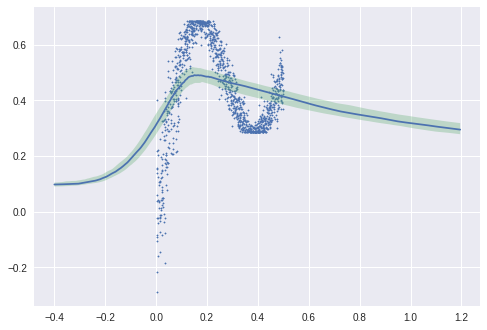

loss: tensor(5407.1543, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5404.8008, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.3534, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5377.3789, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5376.4580, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.9209, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5343.7046, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5344.6484, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.9437, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5313.7939, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5317.0122, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.2183, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5284.5068, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5286.3750, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.8683, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5249.3184, device='cuda:0', grad_fn=<Ad

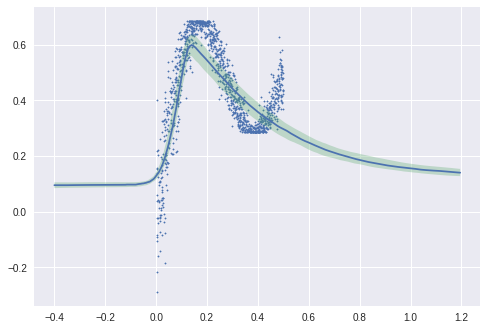

loss: tensor(5098.4946, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5103.0181, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.5237, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5061.3262, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5067.0913, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.7650, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5034.6792, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5039.1050, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.4260, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(5009.4741, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(5012.9072, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.4333, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4977.8813, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4982.1289, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2475, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4946.0317, device='cuda:0', grad_fn=<

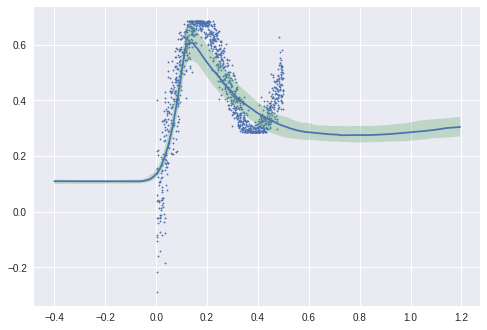

loss: tensor(4798.8955, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4802.0811, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.1855, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4767.3784, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4771.5732, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.1948, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4736.8721, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4741.8369, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.9650, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4708.1113, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4712.1406, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.0291, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4677.5625, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4683.7407, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.1781, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4650.9810, device='cuda:0', grad_fn=<

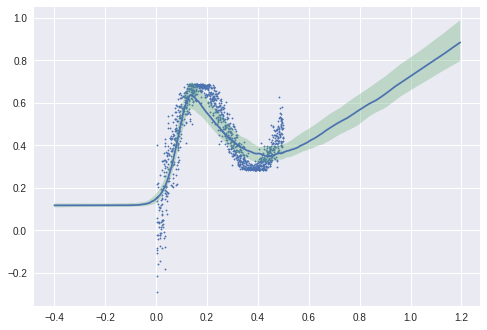

loss: tensor(4505.3267, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4507.8105, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.4840, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4475.0166, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4476.5464, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.5298, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4444.6904, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4447.1289, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.4383, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4416.2891, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4420.6362, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.3472, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4383.7549, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4387.7524, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.9978, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4359.1514, device='cuda:0', grad_fn=<

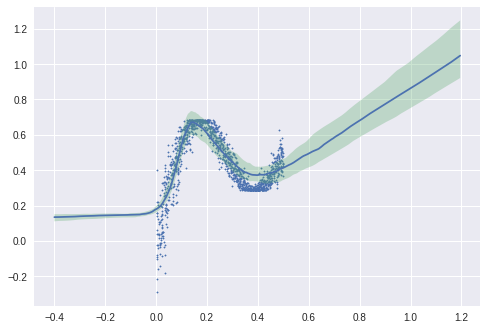

loss: tensor(4215.2852, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4218.6001, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.3151, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4188.3052, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4192.6343, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.3290, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4152.1104, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4155.9609, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.8508, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4127.8477, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4132.6465, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.7987, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4102.1260, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(4105.9512, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.8251, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(4070.3413, device='cuda:0', grad_fn=<

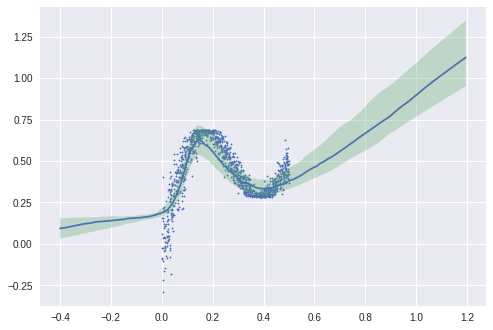

loss: tensor(3935.3491, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3937.9343, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.5852, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3905.1316, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3908.5906, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.4589, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3878.6357, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3883.6895, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.0538, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3852.9580, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3856.4629, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5049, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3824.1243, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3828.2134, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.0892, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3795.5952, device='cuda:0', grad_fn=<

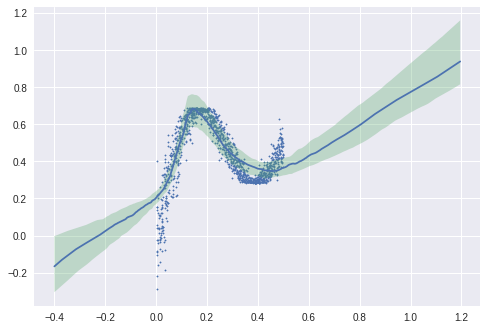

loss: tensor(3658.5830, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3661.6211, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.0382, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3634.2905, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3638.3086, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.0182, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3610.3042, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3613.5898, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.2856, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3579.4417, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3584.3220, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8805, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3553.8638, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3557.1086, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.2449, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3526.4053, device='cuda:0', grad_fn=<

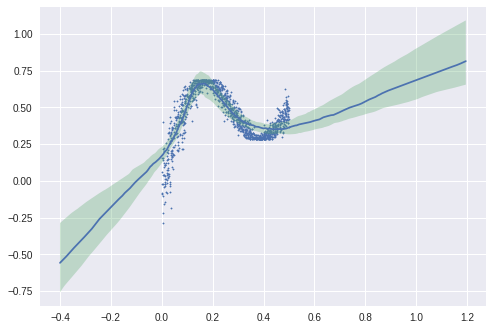

loss: tensor(3398.2419, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3400.5840, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.3419, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3373.3115, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3376.9407, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.6291, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3349.9346, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3353.5239, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5894, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3330.1235, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3331.9900, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.8664, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3305.1467, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3304.1521, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.9947, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3278.5999, device='cuda:0', grad_fn=<A

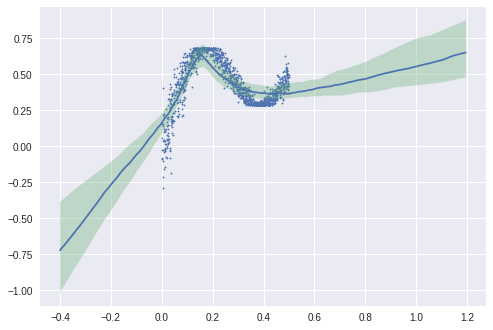

loss: tensor(3154.0554, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3158.2852, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2296, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3135.0759, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3133.2129, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(1.8631, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3107.1746, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3108.6719, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.4973, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3085.2776, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3087.4180, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.1403, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3059.8074, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3061.5103, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.7030, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3035.8286, device='cuda:0', grad_fn=<A

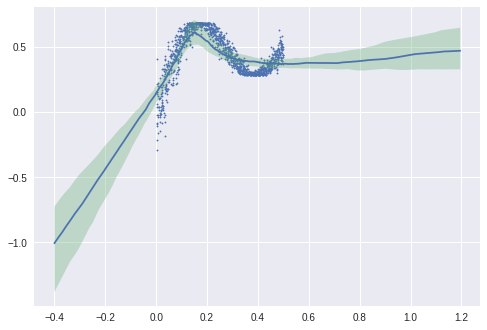

loss: tensor(2923.0100, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2923.5417, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.5317, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2901.4324, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2902.8293, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.3970, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2874.3523, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2876.3784, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.0260, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2852.3521, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2853.4119, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.0599, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2832.7622, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2836.2898, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5275, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2812.8027, device='cuda:0', grad_fn=<

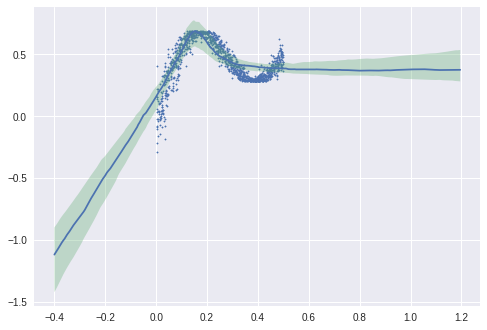

loss: tensor(2710.1487, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2707.6909, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.4579, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2688.4834, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2687.7625, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.7209, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2667.5857, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2666.0532, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(1.5325, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2644.8870, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2647.1057, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.2187, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2627.9539, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2630.1772, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.2234, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2605.7332, device='cuda:0', grad_fn=<Add

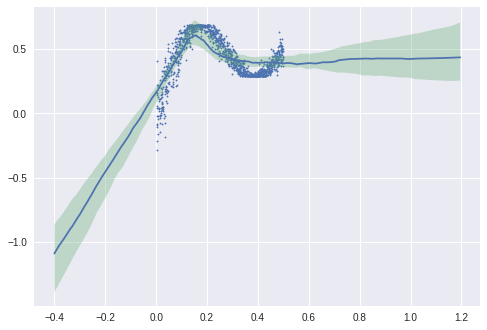

loss: tensor(2504.8530, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2506.8918, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.0389, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2485.3210, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2483.7402, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(1.5808, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2471.9302, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2474.4062, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.4762, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2457.6484, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2453.8247, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(3.8238, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2433.2014, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2435.0024, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.8011, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2414.6040, device='cuda:0', grad_fn=<Ad

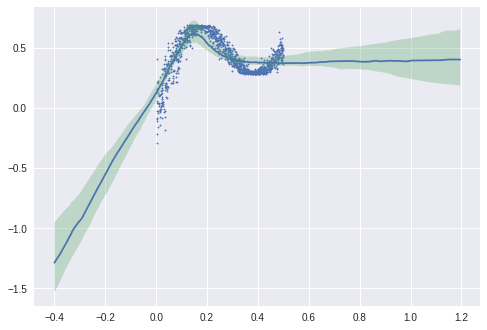

loss: tensor(2329.2900, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2333.8848, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.5947, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2304.2275, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2306.3945, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.1671, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2292.5496, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2294.0356, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.4860, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2274.8672, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2277.2332, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.3660, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2255.7083, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2256.9956, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.2875, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2239.0029, device='cuda:0', grad_fn=<

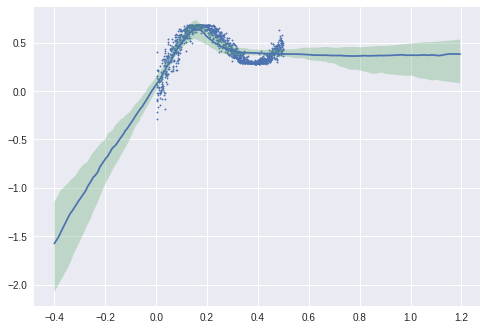

loss: tensor(2158.5540, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2160.6641, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.1102, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2148.9185, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2148.9751, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.0567, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2128.1318, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2128.4919, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.3601, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2112.2524, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2114.2676, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.0152, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2092.4099, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2094.9802, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.5704, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2079.5061, device='cuda:0', grad_fn=<

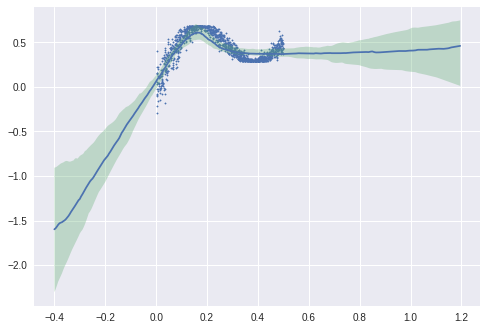

loss: tensor(2010.1768, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2011.8336, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.6569, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1987.7808, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1992.7805, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.9998, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1976.9657, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1979.8420, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.8763, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1964.1056, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1966.4261, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.3206, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1948.6473, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1951.7323, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.0850, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1931.2894, device='cuda:0', grad_fn=<

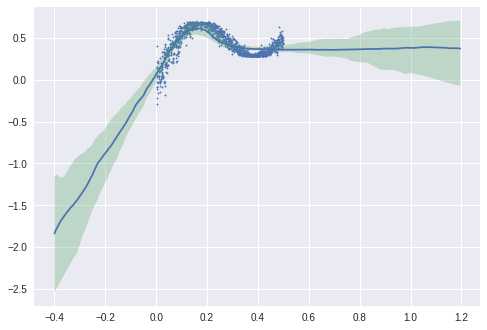

loss: tensor(1876.8983, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1873.9973, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.9010, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1857.5958, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1861.2809, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.6851, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1843.1150, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1847.1371, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.0221, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1829.7151, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1832.2317, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.5166, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1817.4099, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1820.2942, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.8843, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1807.1907, device='cuda:0', grad_fn=<A

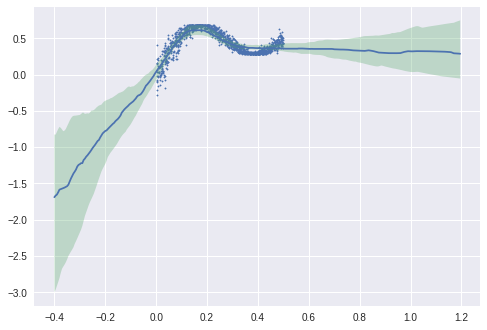

loss: tensor(1746.1351, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1750.6309, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.4957, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1728.5511, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1732.8876, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.3365, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1725.7894, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1728.7450, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.9556, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1711.0261, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1714.4221, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.3960, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1698.8107, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1702.5358, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.7251, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1686.1746, device='cuda:0', grad_fn=<

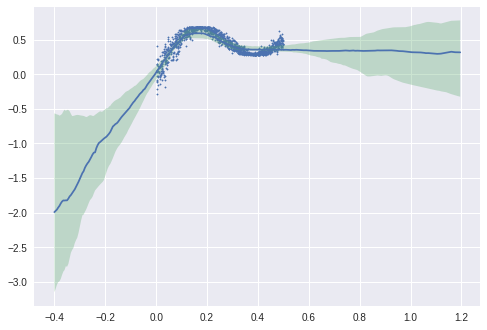

loss: tensor(1630.3159, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1634.7867, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.4709, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1621.3617, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1626.2151, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8534, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1610.2877, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1613.8641, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5764, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1597.5433, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1602.9397, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.3964, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1594.8049, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1597.2555, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.4506, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1579.4656, device='cuda:0', grad_fn=<

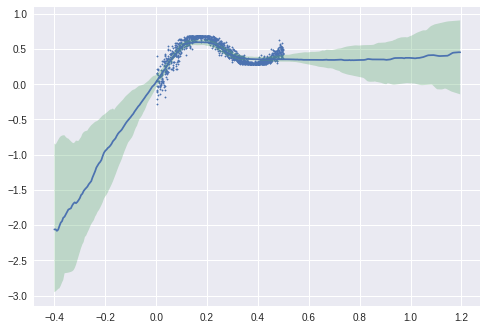

loss: tensor(1537.5781, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1531.8674, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(5.7107, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1519.0291, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1524.2268, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.1978, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1510.0917, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1515.7758, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.6841, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1503.2906, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1506.3190, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.0283, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1494.8483, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1498.6351, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.7869, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1478.1047, device='cuda:0', grad_fn=<A

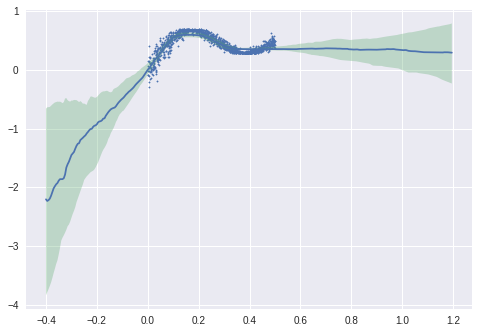

loss: tensor(1434.8037, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1438.3313, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5276, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1428.5798, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1428.2914, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.2885, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1424.1439, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1425.9873, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.8434, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1411.1239, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1416.6057, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.4819, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1404.5679, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1407.0322, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.4644, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1389.8055, device='cuda:0', grad_fn=<A

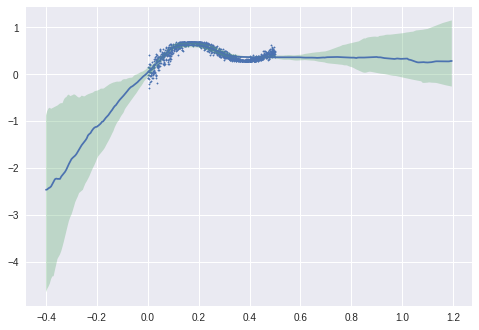

loss: tensor(1349.1409, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1354.9530, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.8121, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1345.3787, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1348.4684, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.0897, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1340.7643, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1344.1633, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.3991, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1331.7877, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1334.8262, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.0384, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1319.8483, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1324.9749, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.1265, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1313.7838, device='cuda:0', grad_fn=<

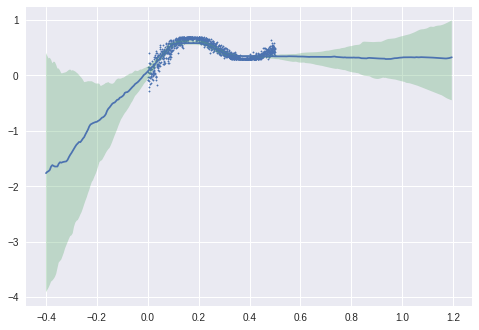

loss: tensor(1275.4186, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1280.9645, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.5460, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1267.5634, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1271.1918, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.6284, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1267.2609, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1269.8417, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.5808, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1252.5143, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1252.6315, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.1172, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1243.2164, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1248.7291, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.5127, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1240.6837, device='cuda:0', grad_fn=<

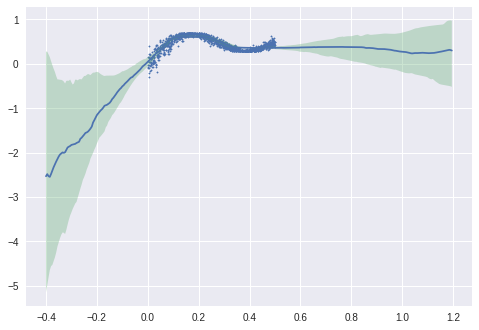

loss: tensor(1201.7877, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1207.4619, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.6742, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1197.9928, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1201.0385, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.0456, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1192.8297, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1197.7963, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.9666, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1181.8805, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1188.0365, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.1560, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1175.9900, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1181.2217, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.2317, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1166.6444, device='cuda:0', grad_fn=<

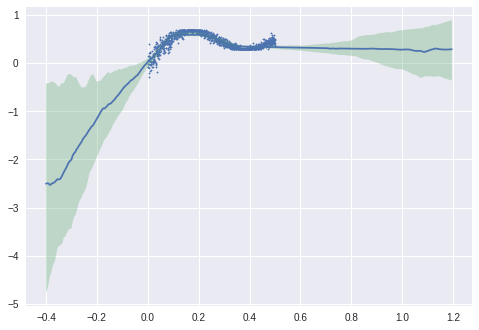

loss: tensor(1138.4794, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1144.4648, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.9855, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1130.5137, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1134.9329, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.4192, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1127.5669, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1131.9945, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.4276, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1120.9753, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1126.6547, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.6794, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1119.6011, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1117.7284, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(1.8726, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1105.5726, device='cuda:0', grad_fn=<A

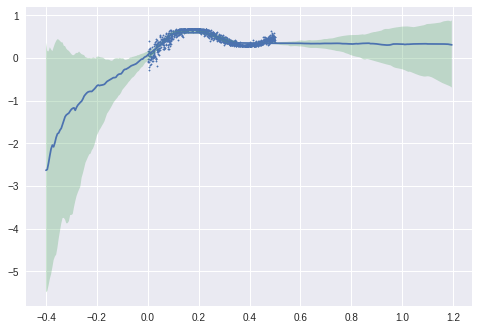

loss: tensor(1077.6094, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1083.1243, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.5149, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1073.2700, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1076.3049, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.0349, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1069.4305, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1070.3174, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.8868, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1064.8909, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1070.1982, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.3073, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1058.9226, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1063.6210, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.6983, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1065.3872, device='cuda:0', grad_fn=<

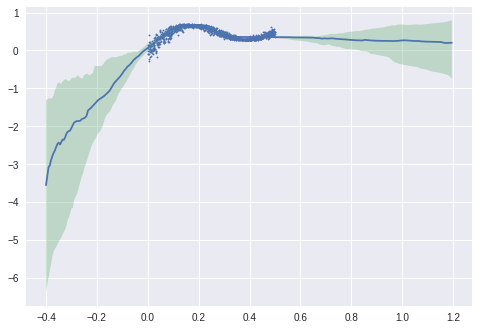

loss: tensor(1024.3174, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1030.3147, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.9974, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1020.7872, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1025.8036, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.0164, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1007.0799, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1013.3768, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.2969, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1007.3215, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1013.1403, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.8187, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1000.4942, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1004.5778, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.0835, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(995.2709, device='cuda:0', grad_fn=<A

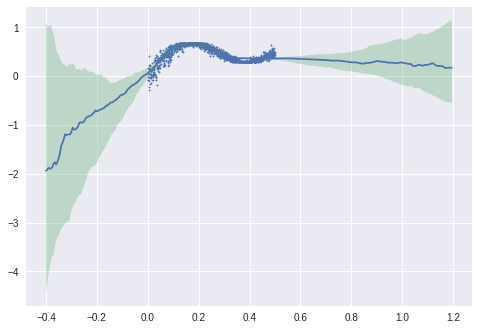

loss: tensor(973.0130, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(978.0867, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.0737, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(966.2661, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(970.1981, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.9320, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(960.9203, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(966.1586, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.2383, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(956.0846, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(960.1352, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.0506, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(948.9492, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(954.0322, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.0830, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(962.9886, device='cuda:0', grad_fn=<AddBackward

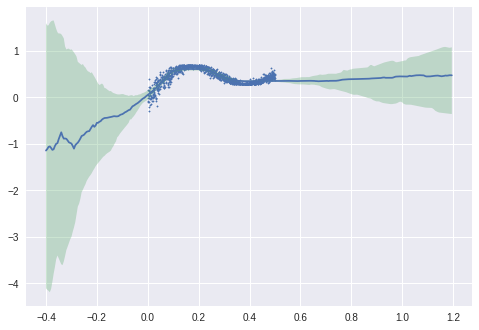

loss: tensor(919.5955, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(926.1541, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.5586, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(925.9783, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(919.6012, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(6.3771, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(912.7926, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(917.6896, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8971, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(907.5977, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(912.5811, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.9833, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(906.9637, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(913.3730, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.4094, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(900.2740, device='cuda:0', grad_fn=<AddBackward0

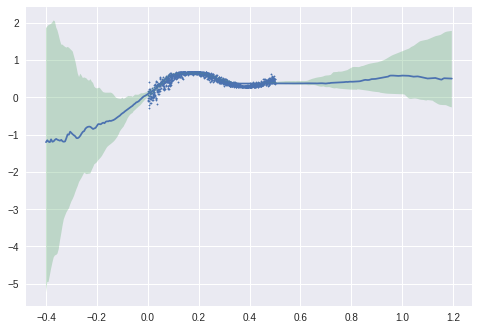

loss: tensor(884.9695, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(889.5312, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.5617, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(875.6729, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(880.0584, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.3855, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(869.7361, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(875.4283, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.6923, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(872.1586, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(877.3268, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.1682, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(861.5792, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(867.3955, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.8163, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(860.5594, device='cuda:0', grad_fn=<AddBackward

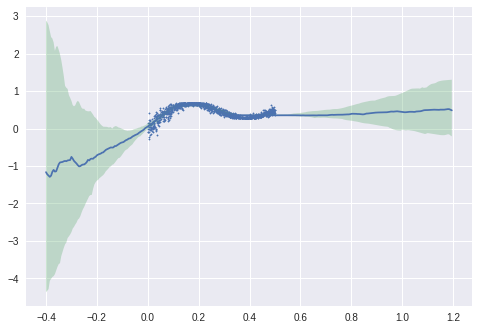

loss: tensor(838.3520, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(843.4072, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.0552, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(832.9592, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(838.5192, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.5600, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(834.6563, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(835.7141, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.0577, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(824.8887, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(829.9924, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.1037, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(820.3483, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(826.3668, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.0186, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(820.4393, device='cuda:0', grad_fn=<AddBackward

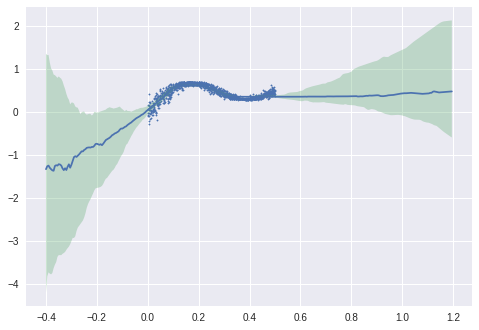

loss: tensor(797.6870, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(802.6428, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.9558, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(794.3574, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(800.5459, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.1885, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(788.8479, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(795.3190, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.4711, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(784.0909, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(789.5778, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.4869, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(788.0416, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(790.7736, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.7320, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(780.1775, device='cuda:0', grad_fn=<AddBackward

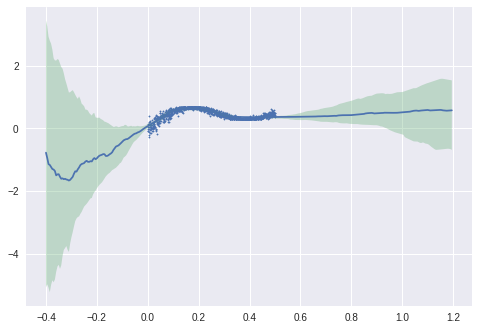

loss: tensor(757.5808, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(763.7756, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.1948, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(756.2692, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(761.0715, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8023, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(754.8649, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(760.5084, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.6435, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(755.0331, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(756.3439, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.3108, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(744.6462, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(750.1395, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.4933, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(747.4484, device='cuda:0', grad_fn=<AddBackward

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

In [0]:
# Training

optimizer = optim.Adam(net.parameters(), lr=0.003)
net.train()

for epoch in range(30001):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        num_batches = len(trainloader)
        # forward + backward + optimize
        loss, kl, nll = net.cost_function(inputs, labels, num_samples=10, ratio=1/num_batches)
        if i % 100 == 0:
          print("loss:", loss)
          print("kl:", kl)
          print("nll:", nll)
        loss.backward()
        optimizer.step()
    
    if(epoch%10==0):
        net.train()
        outputs = []
        for sample_count in range(100):
          outputs.append(net(true_range.view([320, 1])))
        outputs = torch.cat(outputs, dim=1).detach().cpu().numpy()
        output_median = np.median(outputs, axis=1)
        output_lower = np.percentile(outputs, 25, axis=1)
        output_higher = np.percentile(outputs, 75, axis=1)
        plt.plot(true_range.flatten().cpu().numpy(), output_median)
        plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy(),s = 2)
        plt.fill_between(true_range.flatten().cpu().numpy(), output_lower, output_higher, interpolate=True, alpha=0.3)
        plt.plot()
        plt.show()

print('Finished Training')

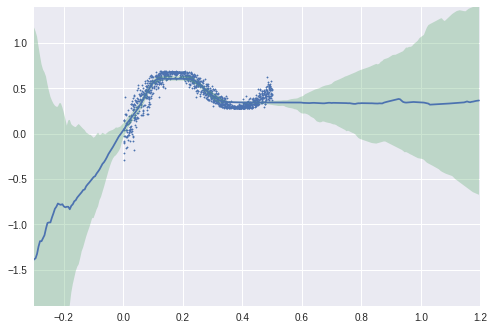

In [0]:
# generate the plot
net.train()
outputs = []
for sample_count in range(100):
  outputs.append(net(true_range.view([320, 1])))
outputs = torch.cat(outputs, dim=1).detach().cpu().numpy()
output_median = np.median(outputs, axis=1)
output_lower = np.percentile(outputs, 25, axis=1)
output_higher = np.percentile(outputs, 75, axis=1)
plt.plot(true_range.flatten().cpu().numpy(), output_median)
plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy(),s = 2)
plt.fill_between(true_range.flatten().cpu().numpy(), output_lower, output_higher, interpolate=True, alpha=0.3)
plt.ylim(-1.9,1.4)
plt.xlim(-0.3, 1.2)
plt.plot()
plt.show()